In [1]:
!pip install pandas_ml
!pip install scikit-learn==0.21
!pip install pandas==0.24.2

In [13]:
import keras
import cv2
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import glob as glb
import pandas as pd
import tensorflow as tf
from __future__ import print_function
from sklearn.metrics import classification_report
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from keras.utils import to_categorical
from pandas_ml import ConfusionMatrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adadelta
from keras import optimizers
from google.colab  import files, drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def getCSV(resultat, path_output):
  """
  input : dict(result), str(path to csv)
  output : obj(df)
  """
  df = pd.DataFrame.from_dict(resultat, orient="index")
  # print(df)
  return df.to_csv(path_output, sep="\t", encoding="utf8")

## Ecriture des résultats

### Utilisation d'un dictionnaire avant de le transformer en dataframe

In [4]:
def getScoreLocuteur(report):
  """
  input : str(classification report)
  output : dict(scores)
  """
  lignes = report.split("\n")
  score = {}
  for n in range(1, len(lignes)):
    # print(lignes[n])
    if lignes[n] != "":
      lignes[n] = lignes[n].strip()
      if 'avg' in lignes[n]: lignes[n] = re.sub(" avg", "_avg",lignes[n])
      data = lignes[n].split()
      if data[0] != "accuracy":
        # print(data)
        score["precision_"+data[0]] = data[1]
        score["recall_"+data[0]] = data[2]
        score["f1_score_"+data[0]] = data[3]
        score["support_"+data[0]] = data[4]
      else:
        score["f1_score_"+data[0]] = data[1]
        score["support_"+data[0]] = data[2]

  return score

### Initiation d'une liste pour sauvegarder les identifiants des locuteurs

In [5]:
def getListLocuteur(path_to_files):
  """
  input : str(path to files)
  output : list(list of speakers)
  """
  locs = list()
  for path in glb.glob(path_to_files):
    loc_file = "_".join(path.split('/')[-1].split('_')[0:6])
    if loc_file not in locs:
      locs.append(loc_file)
  return locs

In [40]:
def getListSegment(path_to_files):
  """
  input : str(path to files)
  output : list(list of segments)
  """
  segments = list()
  for path in glb.glob(path_to_files):
    segment = path.split('/')[-1].split('_')[6]
    if segment not in segments:
      segments.append(segment)
  return segments

### Récupérations et transformations des données : les données à prédire

In [6]:
def getTestSetLocuteur(locuteur, path_input, img_rows=28, img_cols=28, num_classes=2):
  """
  input : str(id_locuteur), str(path to test files), int(image_rows), int(image_cols), int(number-classes)
  output : list(images), list(label)
  """
  x_test_loc = []
  y_test_loc = []
  for path in glb.glob(path_input):
  #print(path)
    fileName = path.split('/')[-1]
  #print(fileName)
  #print(fileName.split('_'))
    if locuteur in fileName: 
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_loc.append(x)
      y_test_loc.append(y)

  #print(len(x_test_loc))
  x_test_loc = np.array(x_test_loc)
  x_test_loc = x_test_loc.reshape(-1, x_test_loc.shape[1],x_test_loc.shape[2],1)
  x_test_loc = x_test_loc.astype('float32')
  x_test_loc /= 255. 

  y_test_loc = np.array(y_test_loc)
  y_test_loc = to_categorical(y_test_loc, num_classes, dtype='float32')
  return x_test_loc, y_test_loc

In [39]:
def getTestSetSegment(segment, path_input, img_rows=28, img_cols=28, num_classes=2):
  """
  input : str(segment), str(path to test files), int(image_rows), int(image_cols), int(number-classes)
  output : list(images), list(label)
  """
  x_test_seg = []
  y_test_seg = []
  for path in glb.glob(path_input):
  #print(path)
    fileName = path.split('/')[-1]
  #print(fileName)
  #print(fileName.split('_'))
    if segment in fileName.split('_')[6]: 
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_seg.append(x)
      y_test_seg.append(y)

  #print(len(x_test_loc))
  x_test_seg = np.array(x_test_seg)
  x_test_seg = x_test_seg.reshape(-1, x_test_seg.shape[1],x_test_seg.shape[2],1)
  x_test_seg = x_test_seg.astype('float32')
  x_test_seg /= 255. 

  y_test_seg = np.array(y_test_seg)
  y_test_seg = to_categorical(y_test_seg, num_classes, dtype='float32')
  return x_test_seg, y_test_seg

## Initiation de la prédiction d'un modèle

In [7]:
def testLocuteur(model, path_output="drive/Shareddrives/ReseauNeurones/resume_resultats/all_score_loc.csv", path_input="drive/Shareddrives/ReseauNeurones/images/test/*/*"):
  """
  input : str(chemin vers les fichiers de test), str(chemin pour sauvegarder le fichier csv)
  output : df[col : scores, line : locuteur]
  """
  resultat = dict()
  locs = getListLocuteur(path_input)

  for locuteur in locs:
    x_test_loc, y_test_loc = getTestSetLocuteur(locuteur, path_input)
    Y_test = np.argmax(y_test_loc, axis=1) # Convert one-hot to index
    y_pred = model.predict_classes(x_test_loc)
    resultat[locuteur] = getScoreLocuteur(classification_report(Y_test, y_pred))

  return getCSV(resultat, path_output)

In [38]:
def testSegment(model, path_output="drive/Shareddrives/ReseauNeurones/resume_resultats/all_score_loc.csv", path_input="drive/Shareddrives/ReseauNeurones/images/test/*/*"):
  """
  input : str(chemin vers les fichiers de test), str(chemin pour sauvegarder le fichier csv)
  output : df[col : scores, line : locuteur]
  """
  resultat = dict()
  segments = getListSegment(path_input)

  for seg in segments:
    x_test_loc, y_test_loc = getTestSetSegment(seg, path_input)
    Y_test = np.argmax(y_test_loc, axis=1) # Convert one-hot to index
    y_pred = model.predict_classes(x_test_loc)
    resultat[seg] = getScoreLocuteur(classification_report(Y_test, y_pred))

  return getCSV(resultat, path_output)

## Récupérations et transformations des données pour construire un modèle

In [8]:
def getDataSet(path_input, img_rows=28, img_cols=28, num_classes=2):
  """
  input : str(path to test files), int(image_rows), int(image_cols), int(number-classes)
  output : list(images), list(label)
  """
  x_data = []
  y_data = []
  fileNames = []
  
  for path in glb.glob(path_input) :
    label = path.split('/')[-2] #nasalité
    x = cv2.imread(path, 0).astype(np.uint8) 
    x = cv2.resize(x, (img_rows, img_cols)) 
    y = dicoLocs[label]
    x_data.append(x) 
    y_data.append(y)
    fileNames.append(path.split('/')[-1])

  x_data = np.array(x_data)
  x_data = x_data.reshape(-1, x_data.shape[1],x_data.shape[2],1)
  x_data = x_data.astype('float32')
  x_data /= 255. 

  y_data = np.array(y_data)
  y_data = to_categorical(y_data, num_classes, dtype='float32')
  
  return x_data, y_data, fileNames

## Construction du classifieur

In [9]:
def keras_RN(x_train, y_train, x_test, y_test, activation, loss, optimizer, num_classes=2, batch_size=10, epochs=115, verbose=1):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(5,5),
                  activation=activation,
                  input_shape=(img_rows, img_cols, 1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (5, 5), activation='tanh'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))
  model.summary()
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            validation_data=(x_test, y_test), 
            callbacks=[es,mc])

  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  best_model=keras.models.load_model('best_model.h5')
  test_loss, test_acc = best_model.evaluate(x_test, y_test)
  val_loss_list=history.history['val_loss']
  best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
  val_acc_list = history.history["val_accuracy"]
  best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

  print("loss on test set : ", test_loss)
  print("accuracy on test set : ", test_acc)
  print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
  print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
  y_pred = model.predict_classes(x_test)
  print(classification_report(Y_test, y_pred))
  
  return model


Hyperparamètres pour le RN

In [10]:
dicoLocs = {'nasal':1, 'non_nasal':0}
labels = [l.split('/')[-1] for l in glb.glob('drive/Shareddrives/ReseauNeurones/images_python/train/*')]
img_rows, img_cols = 28, 28
batch_size = 10
epochs = 115
num_classes = len(labels)

In [11]:
print(dicoLocs)
print(labels)

{'nasal': 1, 'non_nasal': 0}
['nasal', 'non_nasal']


Les données - images et labels

In [14]:
x_train, y_train, fileNames_train = getDataSet('drive/Shareddrives/ReseauNeurones/images_python/train/*/*')
x_test, y_test, fileNames = getDataSet('drive/Shareddrives/ReseauNeurones/images_python/test_aAEI/*/*')

In [15]:
print(len(x_train), len(x_test))
print(y_train)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

19800 5040
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
x_train shape: (19800, 28, 28, 1)
x_test shape: (5040, 28, 28, 1)
19800 train samples
5040 test samples


# Exécution du modèle

##Entraînement 1
    activation : tanh
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
____________________________________________________

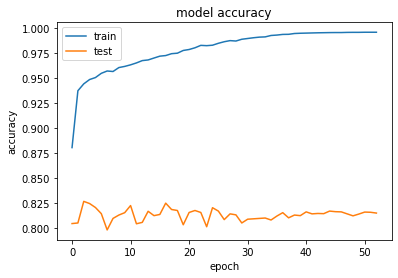

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.81      0.82      0.82      2520
           1       0.82      0.81      0.81      2520

    accuracy                           0.82      5040
   macro avg       0.82      0.82      0.82      5040
weighted avg       0.82      0.82      0.82      5040



In [16]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="tanh", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [17]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model1')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model1/assets


In [41]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model1')

(-0.5, 1.5, 1.5, -0.5)

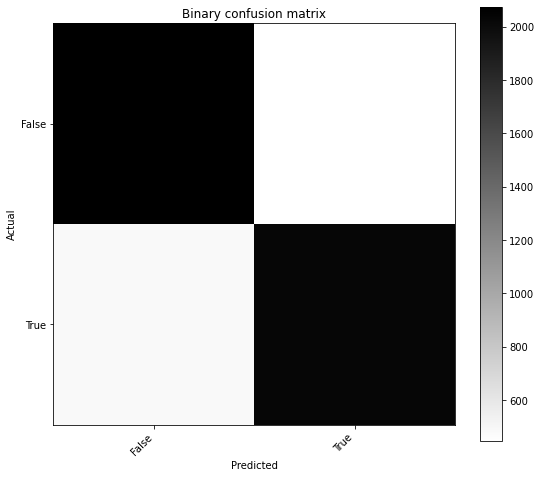

In [19]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [20]:
testLocuteur(model, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_loc_entrainement1.csv", "drive/Shareddrives/ReseauNeurones/images_python/test_aAEI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [36]:
testLocuteur(model, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_loc_entrainement1.csv", "drive/Shareddrives/ReseauNeurones/images_python/test_aAEI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [43]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_seg_entrainement1.csv", "/content/drive/Shareddrives/ReseauNeurones/images_python/test_aAEI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [22]:
proba = model.predict_proba(x_test)
print(proba)

[[9.9079084e-01 9.2091970e-03]
 [1.2933335e-05 9.9998713e-01]
 [5.5213218e-06 9.9999452e-01]
 ...
 [9.9999547e-01 4.5239099e-06]
 [9.9376351e-01 6.2365592e-03]
 [9.9999917e-01 7.8857335e-07]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [23]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

[0.99079084 0.0092092 ]
0.990791
0.009209


In [24]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["contexte_gauche"] = fileNames[i].split('_')[-4]
  score["contexte_droit"] = fileNames[i].split('_')[-3]
  score["contextes"] = fileNames[i].split('_')[-4] + "_" + fileNames[i].split('_')[-3]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_contexte_entrainement1.csv")

##Entraînement 2
    activation : relu
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

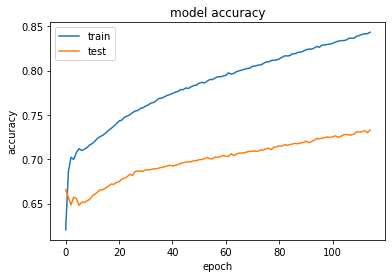

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.73      0.74      0.74      2520
           1       0.74      0.72      0.73      2520

    accuracy                           0.73      5040
   macro avg       0.73      0.73      0.73      5040
weighted avg       0.73      0.73      0.73      5040



In [25]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="relu", loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta())

In [26]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model2')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model2/assets


In [44]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model2')

(-0.5, 1.5, 1.5, -0.5)

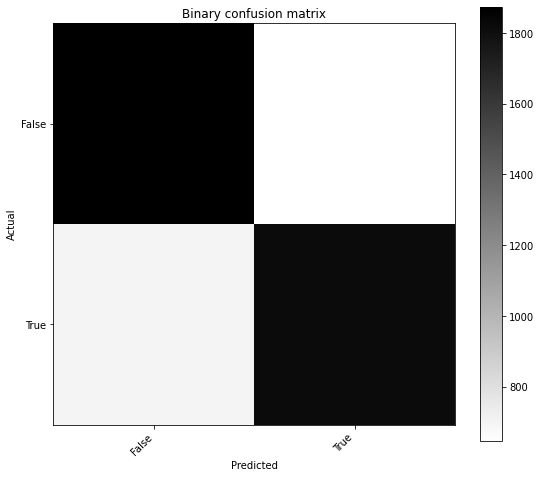

In [28]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [29]:
testLocuteur(model, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_loc_entrainement2.csv", "drive/Shareddrives/ReseauNeurones/images_python/test_aAEI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
testLocuteur(model, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_loc_entrainement2.csv", "drive/Shareddrives/ReseauNeurones/images_python/test_aAEI/*/*")

In [45]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_seg_entrainement2.csv", "/content/drive/Shareddrives/ReseauNeurones/images_python/test_aAEI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [31]:
proba = model.predict_proba(x_test)
print(proba)

[[0.9082809  0.09171908]
 [0.00137174 0.99862826]
 [0.01899054 0.9810095 ]
 ...
 [0.9342018  0.0657982 ]
 [0.7499321  0.25006786]
 [0.63963175 0.36036828]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [32]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

[0.9082809  0.09171908]
0.908281
0.091719


In [33]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["contexte_gauche"] = fileNames[i].split('_')[-4]
  score["contexte_droit"] = fileNames[i].split('_')[-3]
  score["contextes"] = fileNames[i].split('_')[-4] + "_" + fileNames[i].split('_')[-3]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_contexte_entrainement2.csv")


##Entraînement 3
    activation : tanh
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

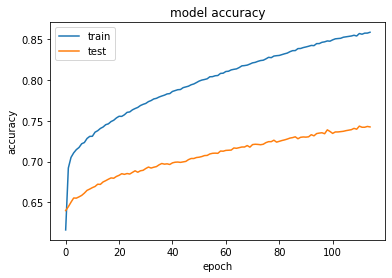

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.72      0.79      0.75      2520
           1       0.77      0.70      0.73      2520

    accuracy                           0.74      5040
   macro avg       0.74      0.74      0.74      5040
weighted avg       0.74      0.74      0.74      5040



In [46]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="tanh", loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta())

In [47]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model3')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model3/assets


In [48]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model3')

(-0.5, 1.5, 1.5, -0.5)

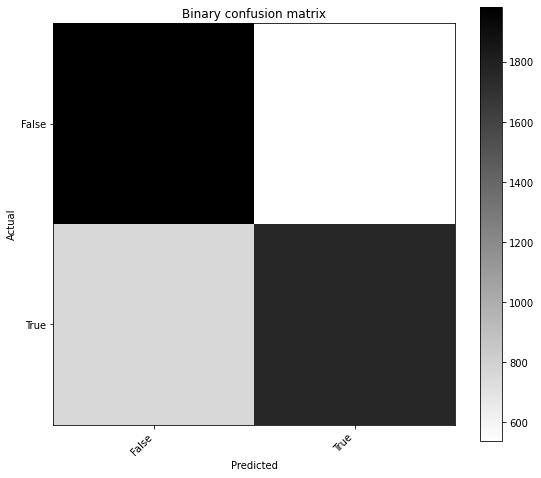

In [49]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [50]:
testLocuteur(model, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_loc_entrainement3.csv", "drive/Shareddrives/ReseauNeurones/images_python/test_aAEI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [51]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_seg_entrainement3.csv", "/content/drive/Shareddrives/ReseauNeurones/images_python/test_aAEI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [52]:
proba = model.predict_proba(x_test)
print(proba)

[[0.9477298  0.05227013]
 [0.00294494 0.99705505]
 [0.04557294 0.954427  ]
 ...
 [0.9543009  0.04569919]
 [0.76264775 0.23735228]
 [0.7645165  0.23548357]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [53]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

[0.9477298  0.05227013]
0.947730
0.052270


In [54]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["contexte_gauche"] = fileNames[i].split('_')[-4]
  score["contexte_droit"] = fileNames[i].split('_')[-3]
  score["contextes"] = fileNames[i].split('_')[-4] + "_" + fileNames[i].split('_')[-3]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_contexte_entrainement3.csv")

##Entraînement 4
    activation : relu
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

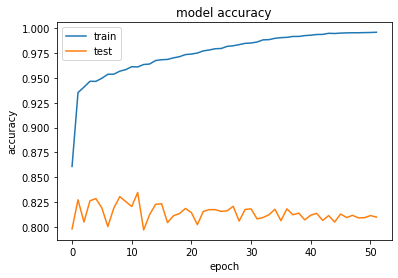

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2520
           1       0.82      0.80      0.81      2520

    accuracy                           0.81      5040
   macro avg       0.81      0.81      0.81      5040
weighted avg       0.81      0.81      0.81      5040



In [55]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="relu", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [56]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model4')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model4/assets


In [57]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/python_train_aA_test_aAEI_model4')

(-0.5, 1.5, 1.5, -0.5)

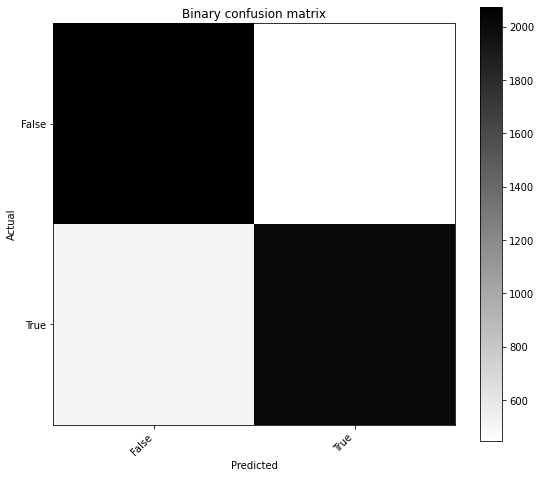

In [58]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [59]:
testLocuteur(model, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_loc_entrainement4.csv", "drive/Shareddrives/ReseauNeurones/images_python/test_aAEI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [60]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_seg_entrainement4.csv", "/content/drive/Shareddrives/ReseauNeurones/images_python/test_aAEI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [61]:
proba = model.predict_proba(x_test)
print(proba)

[[9.9995911e-01 4.0860661e-05]
 [6.3912571e-06 9.9999356e-01]
 [2.2648296e-06 9.9999774e-01]
 ...
 [9.9999976e-01 2.7281510e-07]
 [9.9965942e-01 3.4053807e-04]
 [9.9999928e-01 7.3894262e-07]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [62]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

[9.999591e-01 4.086066e-05]
0.999959
0.000041


In [63]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["contexte_gauche"] = fileNames[i].split('_')[-4]
  score["contexte_droit"] = fileNames[i].split('_')[-3]
  score["contextes"] = fileNames[i].split('_')[-4] + "_" + fileNames[i].split('_')[-3]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/non_troncons/aAEI_python/all_score_contexte_entrainement4.csv")



---

---





Et quelques autres entraînements pour essayer de voir d'où vient la différence au niveau de la progression dans un entraînement...


---

---





In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
          callbacks=[es,mc])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

best_model=keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(x_test, y_test)
val_loss_list=history.history['val_loss']
best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
val_acc_list = history.history["val_accuracy"]
best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

print("loss on test set : ", test_loss)
print("accuracy on test set : ", test_acc)
print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)


In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
          callbacks=[es,mc])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

best_model=keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(x_test, y_test)
val_loss_list=history.history['val_loss']
best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
val_acc_list = history.history["val_accuracy"]
best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

print("loss on test set : ", test_loss)
print("accuracy on test set : ", test_acc)
print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)


In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()